In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Voice Controlled Home Assistant'

Mounted at /content/drive
/content/drive/My Drive/Voice Controlled Home Assistant


# Setting Up

In [ ]:
!pip install tensorflow==1.15
!pip install tensorflow-gpu==1.15
!pip install keras==2.3.0

# Importing Libraries

In [ ]:
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from python_speech_features import mfcc
from utils import calc_feat_dim, spectrogram_from_file, text_to_int_sequence
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import json
from sklearn import preprocessing
import numpy as np
import wave     
import os
import random

from keras.layers import GaussianNoise, Lambda
from keras.optimizers import Adam, SGD
import pickle
from keras.preprocessing import sequence
import numpy as np
# Importing the libraries
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Dropout, MaxPooling1D, Masking)
from CTCModel import CTCModel

Using TensorFlow backend.


In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  1


# Data Section & PreProcessing

In [ ]:
df = pd.read_csv("Fluent/data/train_data.csv")
paths = df['path']
transcriptions = df['transcription']
actions = df['action']
objects = df['object']
locations = df['location']
df.head()

,Unnamed: 0,path,speakerId,transcription,action,object,location
0,0,wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-1...,2BqVo8kVB2Skwgyb,Change language,change language,none,none
1,1,wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-1...,2BqVo8kVB2Skwgyb,Resume,activate,music,none
2,2,wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-1...,2BqVo8kVB2Skwgyb,Turn the lights on,activate,lights,none
3,3,wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-1...,2BqVo8kVB2Skwgyb,Switch on the lights,activate,lights,none
4,4,wavs/speakers/2BqVo8kVB2Skwgyb/1d9f3920-4474-1...,2BqVo8kVB2Skwgyb,Switch off the lights,deactivate,lights,none


## Make & Load Data

In [ ]:
import json

def make_data(data_type):

    for corpus in data_type:
        all = []
        df_list = pd.read_csv("Fluent/data/"+corpus+"_data.csv").values.tolist()
        for row in df_list:
            all.append([ row[1], row[3], row[4], row[5], row[6] ])

        with open("fluent_"+corpus+".json", 'w') as out_file:
            for i in range(len(all)):
                line = json.dumps({'key': all[i][0], 'text': all[i][1], 'action': all[i][2], 'object': all[i][3], 'location': all[i][4]})
                out_file.write(line + '\n')

make_data(['train', 'valid', 'test'])

In [ ]:
def load_data(desc_file):
    # Load Data from Json file
    audio_paths, texts, actions, objects, locations = [], [], [], [], []
    with open(desc_file) as json_line_file:
        for line_num, json_line in enumerate(json_line_file):
            try:
                spec = json.loads(json_line)
                audio_paths.append(spec['key'])
                texts.append(spec['text'])
                actions.append(spec['action'])
                objects.append(spec['object'])
                locations.append(spec['location'])
            except Exception as e:
                print('Error reading line #{}: {}'
                            .format(line_num, json_line))
    return audio_paths, texts, actions, objects, locations

## Define Methods to Extract Feature From Audio

**In this project, we used the MFCC features.**

In [ ]:
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

def featurize_mfcc(audio):
    sample_rate, samples = wavfile.read(audio)
    return mfcc(samples, sample_rate)

def visualize_features(corpus, audio_paths_index, features = "mfcc"):

    audio_paths, texts, actions, objects, locations = load_data(corpus)
    print("Audio Transcript : \t", texts[audio_paths_index])
    print("Audio Detail : \t", actions[audio_paths_index], objects[audio_paths_index], locations[audio_paths_index])
    
    # Read File
    sample_rate, samples = wavfile.read("Fluent/"+audio_paths[audio_paths_index])
    print("Shape of Signal : \n\t" + str(samples.shape))

    fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
    ax1.plot(samples)
    print("\n")
    if features == "mfcc":
        # MFCC Spectrogram Features
        ax2.imshow( featurize_mfcc("Fluent/"+audio_paths[audio_paths_index]) , interpolation='nearest', cmap=cm.jet, origin='lower', aspect='auto')
        ax2.set_title('MFCC Features')
        plt.show()
    elif features == "spectrogram":
        # Spectrogram Features
        spec = spectrogram_from_file(audio_paths[audio_paths_index], 
        step=10, 
        window=20,
        max_freq=8000)
        plot_spectrogram_feature(spec)

Audio Transcript : 	 Turn the bedroom lights off
Audio Detail : 	 deactivate lights bedroom
Shape of Signal : 
	(40124,)




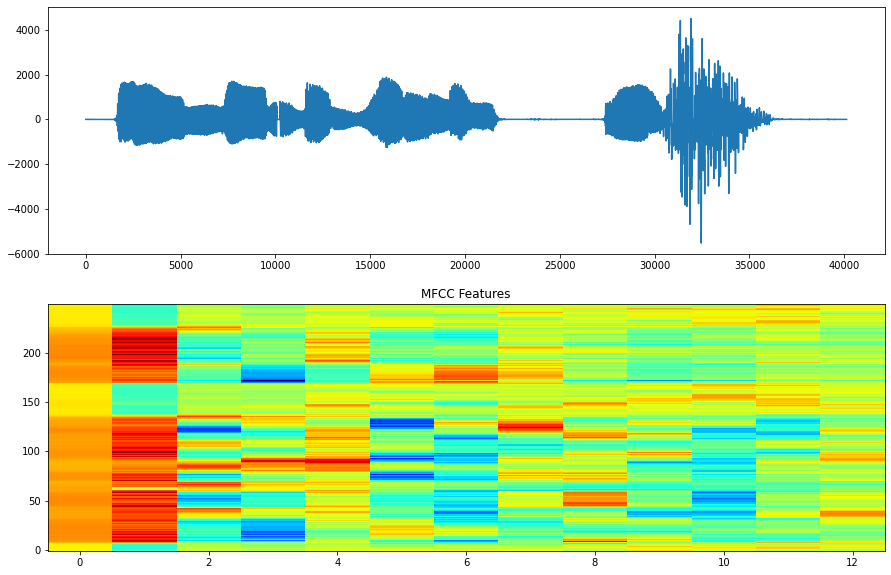

In [ ]:
visualize_features(corpus='fluent_train.json',
                   audio_paths_index=50, 
                   features="mfcc") # features set to mfcc by default, change to spectrogram if needed 

## Preprocessing Labels following this steps

*   Read  the Transcription of each audio
*   Remove Special Characters
*   Convert the text to Phonemes
*   Convert the Phonemes to Integers





In [ ]:
bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\',] 

def remove_characters(text, bad_chars):
    for i in bad_chars : 
        text = text.replace(i, '') 
    return text

In [ ]:
def letters2phonemes(sentence):
    ret_phonemes = []

    for word in sentence.split(' '):
        for line in open('g2p/g2p/mappings/langs/eng/cmudict_SPHINX_40.txt'):
            split = line.strip().split()
            the_word = split[0]
            phonemes = split[1:]
            if the_word.lower() == word:
                phonemes = ' '.join(split[1:]).lower()
                ret_phonemes.append(phonemes)
                break

    return '  '.join(ret_phonemes).split(' ')

In [ ]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        / 28
        / 29
        / -1
        """
        phoneme_map_str = """
        <SPACE> 0
        iy 1
        ih 2
        eh 3
        ae 4
        ah 5
        uw 6
        uh 7
        aa 8
        ey 9
        ay 10
        oy 11
        aw 12
        ow 13
        l 14
        r 15
        y 16
        w 17
        er 18
        m 19
        n 20
        ng 21
        ch 22
        jh 23
        dh 24
        b 25
        d 26
        dx 27
        g 28
        p 29
        t 30
        k 31
        z 32
        v 33
        f 34
        th 35
        s 36
        sh 37
        hh 38
        aa 39
        ao 40
        iy 41
        // -1
        // 255
        """
        
        self.char_map = {}
        self.phoneme_map = {}
        self.index_map = {}
        self.index_map2 = {}

        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

        for line in phoneme_map_str.strip().split('\n'):
            ch, index = line.split()
            self.phoneme_map[ch] = int(index)
            self.index_map2[int(index)] = ch
        self.index_map2[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == "-":
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def phoneme_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == "":
                ch = self.phoneme_map['<SPACE>']
            else:
                ch = self.phoneme_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string)

    def int_to_phoneme(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map2[int(i)])
        return ''.join(string)

#### Example of Processing the labels 

In [ ]:
texts_train[12], letters2phonemes( remove_characters(texts_train[12].lower(), bad_chars) ), text_transform.phoneme_to_int( letters2phonemes( remove_characters(texts_train[12].lower(), bad_chars) ) )

('Turn down the heat',
 ['t', 'er', 'n', '', 'd', 'aw', 'n', '', 'dh', 'ah', '', 'hh', 'iy', 't'],
 [30, 18, 20, 0, 26, 12, 20, 0, 24, 5, 0, 38, 41, 30])

#### This function does all the work mentioned above. Plus we perform a padding on the vectors so that the neural networks receive a fixed input shape. 

In [ ]:
from keras.preprocessing import sequence

def process_data(audio_paths, texts, ratio, bad_chars, padding_value, features = "mfcc"):
    featurized = []
    labels = []
    input_lengths = []
    label_lengths = []
    text_transform = TextTransform()

    audio_paths = audio_paths[:int(len(audio_paths)*ratio)]
    texts = texts[:int(len(texts)*ratio)]
    print("There are "+str(len(audio_paths))+" audio files.")

    i = 0
    for i in range(0, len(audio_paths)):
        if features == "mfcc":
            # audio_feats = preprocessing.normalize(featurize_mfcc(audio_paths[i]))
            audio_feats = featurize_mfcc("Fluent/"+audio_paths[i])

        elif features == "spec":
            audio_feats = preprocessing.normalize(
                spectrogram_from_file("Fluent/"+audio_paths[i], 
                step=10, 
                window=20,
                max_freq=8000)
            )

        try:
            # labels.append( text_transform.text_to_int(texts[i].lower()) )
            labels.append( text_transform.phoneme_to_int( letters2phonemes( remove_characters(texts[i].lower(), bad_chars) ) ) ) 
            featurized.append( audio_feats ) 
            input_lengths.append( audio_feats.shape[0]//2 )
            label_lengths.append( len( text_transform.phoneme_to_int( letters2phonemes( remove_characters(texts[i].lower(), bad_chars) ) ) ) )
        except Exception as e:
            print("e ", i)

        x_train_len = np.asarray([len(featurized[i]) for i in range( len(featurized) )])
        y_train_len = np.asarray([len(labels[i]) for i in range( len(labels) )])
        i+=1

    featurized = sequence.pad_sequences(featurized, padding="post", value=float(padding_value), dtype='float')
    labels = sequence.pad_sequences(labels, padding="post", value=float(padding_value), dtype='int')

    featurized = sequence.pad_sequences(featurized, dtype='float32',
                                        padding="post", truncating='post')
    labels = sequence.pad_sequences(labels, dtype='float32',
                                        padding="post", truncating='post')

    return featurized, labels, np.array(input_lengths), np.array(label_lengths)

## Make Training & Validation Data

#### input length has to be longer than label
##### It would be logical for the length of the text/label to be shorter than the lenght of the audio/input.

In [ ]:
audio_paths_train, texts_train, actions_train, objects_train, locations_train = load_data('fluent_train.json')
print("Generating Training Data...")
featurized_train, labels_train, input_lengths_train, label_lengths_train = process_data(audio_paths_train, 
                                                    texts_train, 
                                                    ratio=1,
                                                    bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\'], 
                                                    padding_value=255,
                                                    features="mfcc")

print("Data Generated\n")
print("-"*100)
print("Deleting Longer Labels...")

featurized, labels, input_lengths, label_lengths = [], [], [], []
i = 0

for f, l, il, ll in zip(featurized_train, labels_train, input_lengths_train, label_lengths_train):    
    if il > ll:
        featurized.append(f)
        labels.append(l),
        input_lengths.append(il)
        label_lengths.append(ll)
    else: 
        print("Index : ", i)
    i += 1

print("Longer Labels Deleted")
print("-"*100)
print("Saving Data...")

np.save("fluent_featurized.npy", featurized)
np.save("fluent_labels.npy", labels)
np.save("fluent_input_lengths.npy", input_lengths)
np.save("fluent_label_lengths.npy", label_lengths)
print("Train Data Saved !")

Generating Training Data...
There are 23132 audio files.
Data Generated

----------------------------------------------------------------------------------------------------
Deleting Longer Labels...
Index :  8447
Longer Labels Deleted
----------------------------------------------------------------------------------------------------
Saving Data...
Train Data Saved !


In [ ]:
audio_paths_valid, texts_valid, actions_valid, objects_valid, locations_valid = load_data('fluent_valid.json')
print("Generating Validation Data...")
featurized_valid, labels_valid, input_lengths_valid, label_lengths_valid = process_data(audio_paths_valid, 
                                                    texts_valid, 
                                                    ratio=1,
                                                    bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\'], 
                                                    padding_value=255,
                                                    features="mfcc")

print("Data Generated\n")
print("-"*100)
print("Deleting Longer Labels...")

featurized, labels, input_lengths, label_lengths = [], [], [], []
i = 0

for f, l, il, ll in zip(featurized_valid, labels_valid, input_lengths_valid, label_lengths_valid):    
    if il > ll:
        featurized.append(f)
        labels.append(l),
        input_lengths.append(il)
        label_lengths.append(ll)
    else: 
        print("Index : ", i)
    i += 1

print("Longer Labels Deleted")
print("-"*100)
print("Saving Data...")

np.save("fluent_featurized_valid.npy", featurized)
np.save("fluent_labels_valid.npy", labels)
np.save("fluent_input_lengths_valid.npy", input_lengths)
np.save("fluent_label_lengths_valid.npy", label_lengths)
print("Validation Data Saved !")

Generating Validation Data...
There are 3118 audio files.
Data Generated

----------------------------------------------------------------------------------------------------
Deleting Longer Labels...
Longer Labels Deleted
----------------------------------------------------------------------------------------------------
Saving Data...
Validation Data Saved !


# Load Data

In [ ]:
# Load Train & Valid Data

fluent_featurized_train = np.load("fluent_featurized.npy")
fluent_labels_train = np.load("fluent_labels.npy")
fluent_input_lengths_train = np.load("fluent_input_lengths.npy")
fluent_label_lengths_train = np.load("fluent_label_lengths.npy")

fluent_featurized_valid = np.load("fluent_featurized_valid.npy")
fluent_labels_valid = np.load("fluent_labels_valid.npy")
fluent_input_lengths_valid = np.load("fluent_input_lengths_valid.npy")
fluent_label_lengths_valid = np.load("fluent_label_lengths_valid.npy")

In [ ]:
# Text is preprocessed (special characters and removed)
print(remove_characters(texts_test[index].lower(), bad_chars))
# Text is Converted to phonemes
print( letters2phonemes( remove_characters(texts_test[index].lower(), bad_chars) ) )
# Converted to integers using a map/dictionnary
print(text_transform.phoneme_to_int( letters2phonemes( remove_characters(texts_test[index].lower(), bad_chars) ) ))
# Example of a predicted sentence by the model
print(text_transform.int_to_phoneme( text_transform.phoneme_to_int( letters2phonemes( remove_characters(texts_test[index].lower(), bad_chars) ) ) ))

pause the music
['p', 'ao', 'z', '', 'dh', 'ah', '', 'm', 'y', 'uw', 'z', 'ih', 'k']
[29, 40, 32, 0, 24, 5, 0, 19, 16, 6, 32, 2, 31]
paoz<SPACE>dhah<SPACE>myuwzihk


# Modeling

**You can use either RNNs, LSTMs or GRUs.<br>
In this project we used GRUs, because compared to LSTMs, they perform well with small amount of Data.**
**The CTC function we used is from github : https://github.com/cyprienruffino/CTCModel**

In [ ]:
def final_model(input_dim, units, output_dim, padding_value):

    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    masked_input = Masking(mask_value = padding_value)(input_data)

    bidirectional_rnn_1 = Bidirectional(GRU(256, activation=None, return_sequences=True, implementation=2, name='bidir_rnn_1'))(masked_input)
    activation = Activation('relu')(bidirectional_rnn_1)
    drop = Dropout(rate = 0.6)(activation)

    bidirectional_rnn_2 = Bidirectional(GRU(256, activation=None, return_sequences=True, implementation=2, name='bidir_rnn_2'))(activation)
    activation = Activation('relu')(bidirectional_rnn_2)
    drop = Dropout(rate = 0.6)(activation)

    time_dense = TimeDistributed(Dense(output_dim))(activation)
    y_pred = Activation('softmax', name='softmax')(time_dense)

    model = CTCModel.CTCModel([input_data], [y_pred])
    model.compile( optimizer=Adam(lr=0.0001) )
    
    model.summary()
    return model

training_model = final_model(input_dim=13, output_dim=43, units=256, padding_value=255)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 13)     0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None, 13)     0           the_input[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 512)    414720      masking_1[0][0]                  
__________________________________________________________________________________________________
activation_1 (Ac

# Training

In [ ]:
hist = training_model.fit(x=[fluent_featurized_train[:15000], fluent_labels_train[:15000], fluent_input_lengths_train[:15000], fluent_label_lengths_train[:15000]],
        y=np.zeros(len(fluent_featurized_train[:15000])),
        batch_size = 32,    
        validation_data = ([fluent_featurized_valid, fluent_labels_valid, fluent_input_lengths_valid, fluent_label_lengths_valid], np.zeros(len(fluent_featurized_valid))),
        epochs = 10,
        path = 'final_results')

training_model.save_model('final_results')

Train on 15000 samples, validate on 3118 samples
Epoch 1/10
15000/15000 [==============================] - 2913s 194ms/step - loss: 72.3196 - val_loss: 62.9383
Epoch 2/10
15000/15000 [==============================] - 2891s 193ms/step - loss: 56.8358 - val_loss: 56.1487
Epoch 3/10
15000/15000 [==============================] - 2893s 193ms/step - loss: 47.6332 - val_loss: 46.8984
Epoch 4/10
15000/15000 [==============================] - 2881s 192ms/step - loss: 37.9665 - val_loss: 40.5452
Epoch 5/10
15000/15000 [==============================] - 2878s 192ms/step - loss: 30.9828 - val_loss: 36.0147
Epoch 6/10
15000/15000 [==============================] - 2878s 192ms/step - loss: 26.4008 - val_loss: 32.4349
Epoch 7/10
15000/15000 [==============================] - 2852s 190ms/step - loss: 23.1889 - val_loss: 31.7060
Epoch 8/10
15000/15000 [==============================] - 2835s 189ms/step - loss: 21.1642 - val_loss: 29.5339
Epoch 9/10
15000/15000 [==============================] - 2826s

In [ ]:
hist2 = training_model.fit(x=[fluent_featurized_train[15000:23000], fluent_labels_train[15000:23000], fluent_input_lengths_train[15000:23000], fluent_label_lengths_train[15000:23000]],
        y=np.zeros(len(fluent_featurized_train[15000:23000])),
        batch_size = 64,
        validation_data = ([fluent_featurized_valid, fluent_labels_valid, fluent_input_lengths_valid, fluent_label_lengths_valid], np.zeros(len(fluent_featurized_valid))),
        epochs = 5,
        path = 'final_results')

training_model.save_model('final_results')

Train on 8000 samples, validate on 3118 samples
Epoch 1/5
8000/8000 [==============================] - 785s 98ms/step - loss: 24.3578 - val_loss: 26.7952
Epoch 2/5
8000/8000 [==============================] - 783s 98ms/step - loss: 20.4547 - val_loss: 25.7041
Epoch 3/5
8000/8000 [==============================] - 783s 98ms/step - loss: 18.2655 - val_loss: 25.7582
Epoch 4/5
8000/8000 [==============================] - 783s 98ms/step - loss: 16.4976 - val_loss: 25.4756
Epoch 5/5
8000/8000 [==============================] - 782s 98ms/step - loss: 15.2941 - val_loss: 25.7252


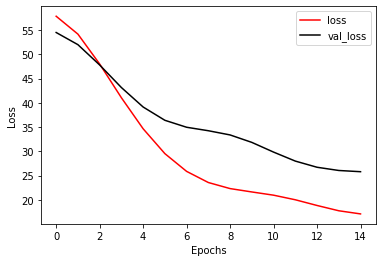

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

loss = hist.history['loss'] + hist2.history['loss']
val_loss = hist.history['val_loss'] + hist2.history['val_loss']

losssmoothed = gaussian_filter1d(loss, sigma=2)
vallosssmoothed = gaussian_filter1d(val_loss, sigma=2)
# multiple line plot
plt.plot(losssmoothed, label='loss', color='red')
plt.plot(vallosssmoothed, label='val_loss', color='black')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Testing

# Generate Testing Data

In [ ]:
audio_paths_test, texts_test, actions_test, objects_test, locations_test = load_data('fluent_test.json')
featurized_test, labels_test, input_lengths_test, label_lengths_test = process_data(audio_paths_test, 
                                                        texts_test, 
                                                        ratio=1, 
                                                        bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\'], 
                                                        padding_value=255, 
                                                        features="mfcc")

print("Data Generated\n")
print("-"*100)
print("Deleting Longer Labels...")

featurized, labels, input_lengths, label_lengths = [], [], [], []
i = 0

for f, l, il, ll in zip(featurized_test, labels_test, input_lengths_test, label_lengths_test):    
    if il > ll:
        featurized.append(f)
        labels.append(l)
        input_lengths.append(il)
        label_lengths.append(ll)
    else: 
        print("Index : ", i)
    i += 1

print("Longer Labels Deleted")
print("-"*100)
print("Saving Data...")

np.save("fluent_featurized_test.npy", featurized)
np.save("fluent_labels_test.npy", labels)
np.save("fluent_input_lengths_test.npy", input_lengths)
np.save("fluent_label_lengths_test.npy", label_lengths)
print("Testing Data Saved !")

There are 3793 audio files.
Data Generated

----------------------------------------------------------------------------------------------------
Deleting Longer Labels...
Longer Labels Deleted
----------------------------------------------------------------------------------------------------
Saving Data...
Testing Data Saved !


In [ ]:
featurized_test = np.load("fluent_featurized_test.npy")
labels_test = np.load("fluent_labels_test.npy")
input_lengths_test = np.load("fluent_input_lengths_test.npy")
label_lengths_test = np.load("fluent_label_lengths_test.npy")

In [ ]:
pred = training_model.predict(x=[featurized_test[:3700], input_lengths_test[:3700]], batch_size=16)

In [ ]:
np.save("predictions.npy", pred)

In [ ]:
pred = np.load("predictions.npy", allow_pickle=True)

In [ ]:
def phonemes2text(sentence):
    ret_text = []
    
    # print( " ".join(sentence.split('<SPACE>')) )
    for word in sentence.split('<SPACE>'):

        for line in open('g2p/g2p/mappings/langs/eng/cmudict_SPHINX_40.txt'):
            split = line.strip().split() # the_word split[0] /// phonemes split[1:]
            wordInPh = remove_characters(" ".join(split[1:]), [' ']).lower()

            if word == wordInPh:
                ret_text.append(split[0])
                break
            
            else:
                # ret_text.append("WHAT ?")
                # print('none')
                continue
                
    return " ".join(ret_text)

phonemes2text("tern<SPACE>aof<SPACE>dhah<SPACE>myuwzk")

'TURN OFF THE'

In [ ]:
text_transform = TextTransform()
print("There are ", len(featurized_test[:3700]), " audio samples.")
index = int(input("Enter audio index : "))

pred[index] = [int(i) for i in pred[index]]
labels_test[index] = [int(i) for i in labels_test[index]]

print('-'*80)

print("Predicted Transcript :",  pred[index] )
print('-'*80)
print("Actual Transcript :",  labels_test[index], '\n' )
# Convert to Phonemes & Transcript
print('*'*80)
print("CONVERT TO PHONEMES")
print('*'*80)
print("\nPredicted Phonemes :", remove_characters(text_transform.int_to_phoneme( pred[index] ), bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\']) )
print('-'*80)
print("Actual Phonemes :",  remove_characters(text_transform.int_to_phoneme( labels_test[index] ), bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\']) )
print("\n")
print('*'*80)
print("CONVERT TO PHONEMES")
print('*'*80)
print("\nPredicted Transcript :", phonemes2text( remove_characters(text_transform.int_to_phoneme( pred[index] ), bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\']) ) )
print('-'*80)
print("Actual Transcript :",  phonemes2text( remove_characters(text_transform.int_to_phoneme( labels_test[index] ), bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\']) ) )

# 100% Accurate Predictions index : 2214, 500, 1325, 497
# Good Predictions index : 500, 63, 997, 3000, 2000, 167
# Almost Good Predictions index : 510, 620, 630, 225, 3669
# Bad Predictions index : 3250, 3674, 1000, 1598

There are  3700  audio samples.
Enter audio index : 2214
--------------------------------------------------------------------------------
Predicted Transcript : [36, 17, 2, 22, 0, 39, 20, 0, 24, 5, 0, 14, 10, 30, 36, 0, 2, 20, 0, 24, 5, 0, 25, 3, 26, 15, 6, 19]
--------------------------------------------------------------------------------
Actual Transcript : [ 36.  17.   2.  22.   0.  39.  20.   0.  24.   5.   0.  14.  10.  30.
  36.   0.   2.  20.   0.  24.   5.   0.  25.   3.  26.  15.   6.  19.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.] 

********************************************************************************
CONVERT TO PHONEMES
********************************************************************************

Predicted Phonemes : swihch<SPACE>aan<SPACE>dhah<SPACE>layts<SPACE>ihn<SPACE>dhah<SPACE>behdruwm
--------------------------------------------------------------------------------
Actual Phonemes : swihch<SPACE>aan<SPACE>dhah<SPACE>layts<SP

## Convert to text

In [ ]:
def WER(pred, actual):

    diff = []
    error = []

    for prediction, truth in zip(pred, actual):
        diff = []
        prediction = remove_characters(text_transform.int_to_phoneme( prediction ).replace('<SPACE>', ' <SPACE> '), bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\', ])
        truth = remove_characters(text_transform.int_to_phoneme( truth ).replace('<SPACE>', ' <SPACE> '), bad_chars = [';', ':', '!', '*', ',', '.', '?', '/', '\\'])

    
        for item in prediction.split(' '):
            if item not in truth.split(' '):
                diff.append(item)

        
        error.append((len(diff) / len(prediction.split(' '))) * 100)

        # break
    print("WER : ",sum(error) / len(error)  )

WER(pred, labels_test)

WER :  36.63525451728434
